In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as squarify

from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()

driver = os.getenv("DRIVER").replace("{", "").replace("}", "")
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
trusted_connection = os.getenv("TRUSTED_CONNECTION")

connection_string = f"mssql+pyodbc://{server}/{database}?driver={driver}&trusted_connection={trusted_connection}"
engine = create_engine(connection_string)


**Contar empleados activos por turno**

Determina cuántos empleados están asignados a cada turno de trabajo (Shift) y visualiza los resultados

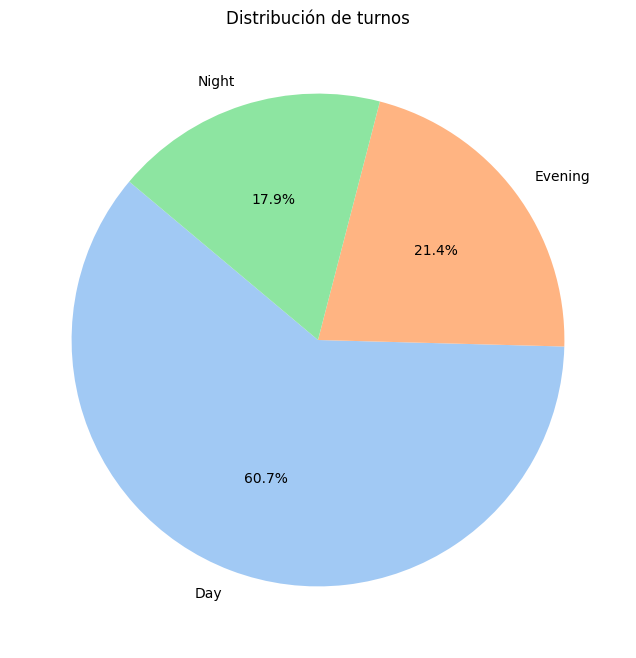

In [43]:
query = """
SELECT HRShift.Name AS Turno,count(*) as UsuariosActivosPorTurno
FROM HumanResources.EmployeeDepartmentHistory HRDepartmentHistory
JOIN HumanResources.Shift HRShift
	ON HRShift.ShiftID = HRDepartmentHistory.ShiftID
WHERE HRDepartmentHistory.EndDate IS NULL
GROUP BY HRShift.Name;
"""
df = pd.read_sql(query, engine)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.pie(df["UsuariosActivosPorTurno"], labels=df["Turno"], autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribución de turnos")
plt.show()

**Analizar la duración promedio de los turnos**

Calcula la duración promedio de los turnos en horas y analiza cuál es el turno más largo y el más corto.

**_No existen turno más largo ni más corto._**

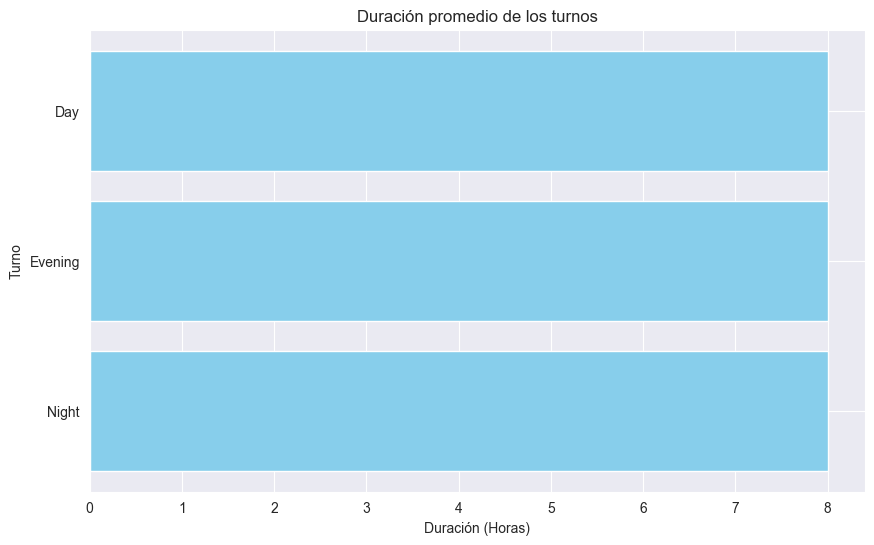

In [12]:
query = """
SELECT HRShift.Name AS Turno,
     CASE
        WHEN HRShift.EndTime < HRShift.StartTime THEN
            DATEDIFF(MINUTE,
                     CAST(HRShift.StartTime AS DATETIME),
                     DATEADD(DAY, 1, CAST(HRShift.EndTime AS DATETIME))) / 60
        ELSE
            DATEDIFF(MINUTE,
                     CAST(HRShift.StartTime AS DATETIME),
                     CAST(HRShift.EndTime AS DATETIME)) / 60
    END AS DuracionHoras
FROM HumanResources.Shift HRShift
ORDER BY DuracionHoras DESC;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.barh(df["Turno"], df["DuracionHoras"], color="skyblue")
plt.xlabel("Duración (Horas)")
plt.ylabel("Turno")
plt.title("Duración promedio de los turnos")
plt.gca().invert_yaxis()
plt.show()

**Historial de cambios de departamento**

Identifica cuántos empleados han cambiado de departamento al menos una vez y visualiza los cambios más frecuentes.

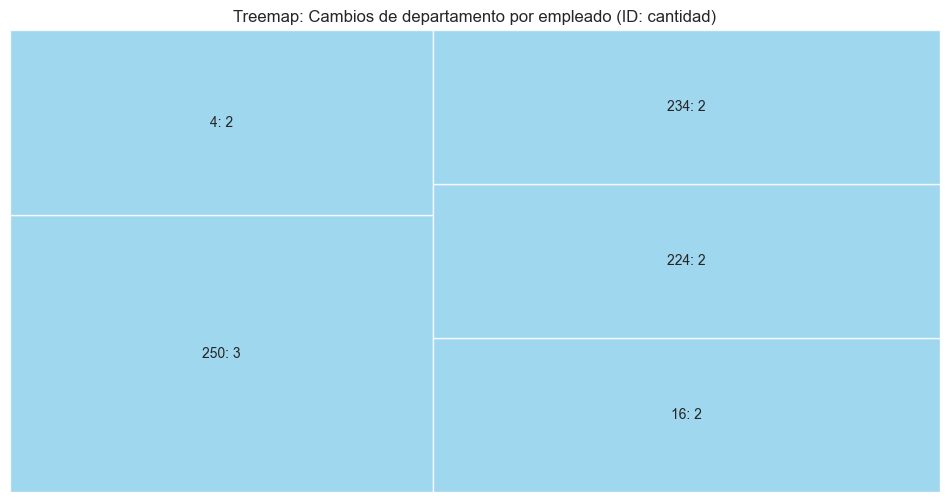

In [5]:
query = """
SELECT
    HRDepartmentHistory.BusinessEntityID,
    COUNT(*) AS CantidadCambios
FROM HumanResources.EmployeeDepartmentHistory HRDepartmentHistory
GROUP BY HRDepartmentHistory.BusinessEntityID
HAVING COUNT(*) > 1
ORDER BY CantidadCambios DESC;
"""
df = pd.read_sql(query, engine)
etiquetas = [f"{id}: {cambios}" for id, cambios in zip(df["BusinessEntityID"], df["CantidadCambios"])]
plt.figure(figsize=(12, 6))
squarify.plot(sizes=df["CantidadCambios"], label=etiquetas, alpha=0.8, color="skyblue")
plt.title("Treemap: Cambios de departamento por empleado (ID: cantidad)")
plt.axis("off")
plt.show()

**Distribución de empleados por departamento**

Obtén la distribución de empleados en cada departamento y representa los datos en un gráfico de barras o pastel

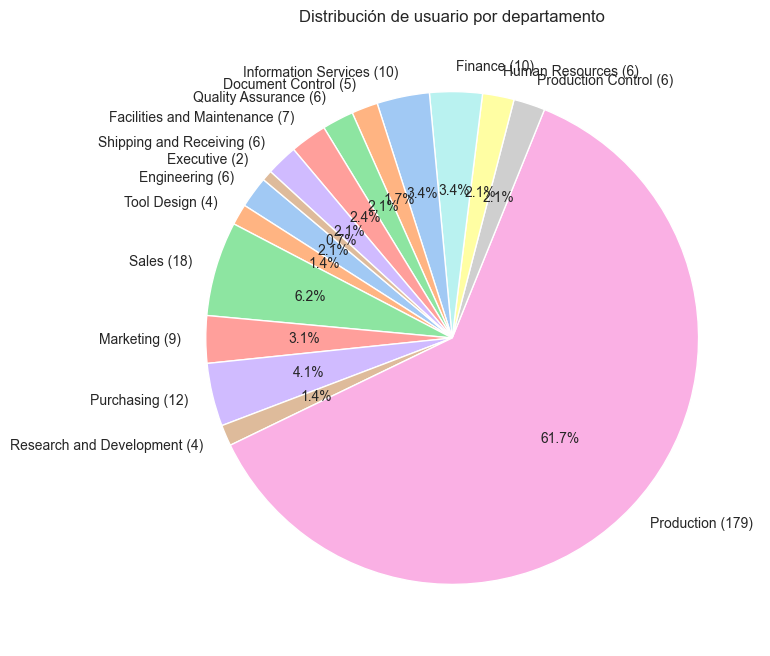

In [6]:
query = """
SELECT HRDepartment.Name AS Departamento ,count(*) as UsuariosPorDepartamento
FROM HumanResources.EmployeeDepartmentHistory HRDepartmentHistory
JOIN HumanResources.Employee HREmployee
	ON HREmployee.BusinessEntityID = HRDepartmentHistory.BusinessEntityID
JOIN HumanResources.Department HRDepartment
    ON HRDepartment.DepartmentID = HRDepartmentHistory.DepartmentID
WHERE HRDepartmentHistory.EndDate IS NULL
GROUP BY HRDepartment.Name;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(8, 8))
labels = [f"{dept} ({count})" for dept, count in zip(df["Departamento"], df["UsuariosPorDepartamento"])]
plt.pie(df["UsuariosPorDepartamento"], labels=labels, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribución de usuario por departamento")
plt.show()

**Evolución del salario promedio**

Analiza cómo ha cambiado el salario promedio de los empleados a lo largo del tiempo utilizando el historial de pagos (EmployeePayHistory).

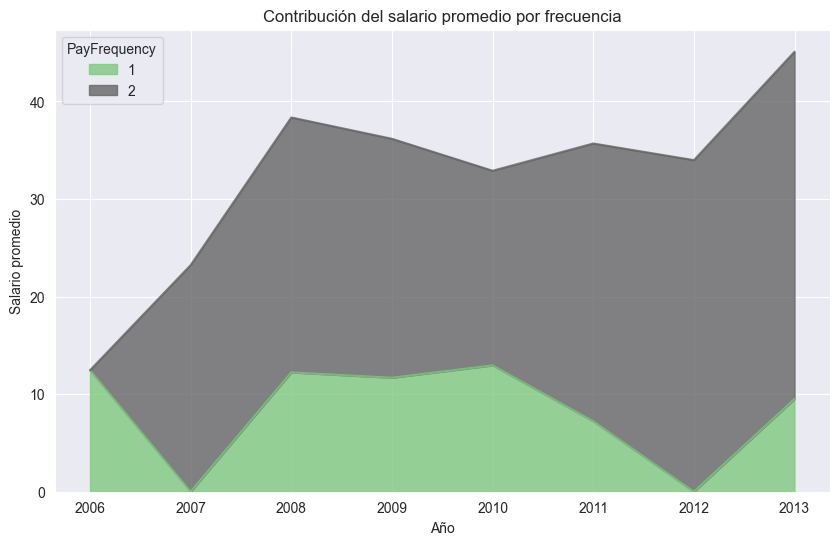

In [18]:
query = """
SELECT EPH.RateChangeDate AS Año, EPH.PayFrequency, AVG(EPH.Rate) AS SalarioPromedio
FROM HumanResources.EmployeePayHistory EPH
GROUP BY EPH.RateChangeDate, EPH.PayFrequency
ORDER BY Año, PayFrequency;
"""
df = pd.read_sql(query, engine)

df["Año"] = pd.to_datetime(df["Año"]).dt.year
pivot_df = df.pivot_table(index="Año", columns="PayFrequency", values="SalarioPromedio")

pivot_df.plot(kind="area", stacked=True, figsize=(10, 6), cmap="Accent", alpha=0.8)
plt.title("Contribución del salario promedio por frecuencia")
plt.ylabel("Salario promedio")
plt.xlabel("Año")
plt.grid(True)
plt.show()


**Identificar departamentos sin empleados**

Encuentra los departamentos que actualmente no tienen empleados asignados. No hay ningún departamento sin empleados.

In [20]:
query ="""
SELECT HRD.Name AS Departamento
FROM HumanResources.Department HRD
LEFT JOIN HumanResources.EmployeeDepartmentHistory HREDH
    ON HRD.DepartmentID = HREDH.DepartmentID
    AND HREDH.EndDate IS NULL
WHERE HREDH.BusinessEntityID IS NULL
ORDER BY HRD.Name;
"""
df = pd.read_sql(query, engine)
print(df.head())

Empty DataFrame
Columns: [Departamento]
Index: []


**Comparar salarios por departamento**

Calcula el salario promedio por departamento y determina cuál tiene el salario más alto y cuál el más bajo.


<Figure size 800x800 with 0 Axes>

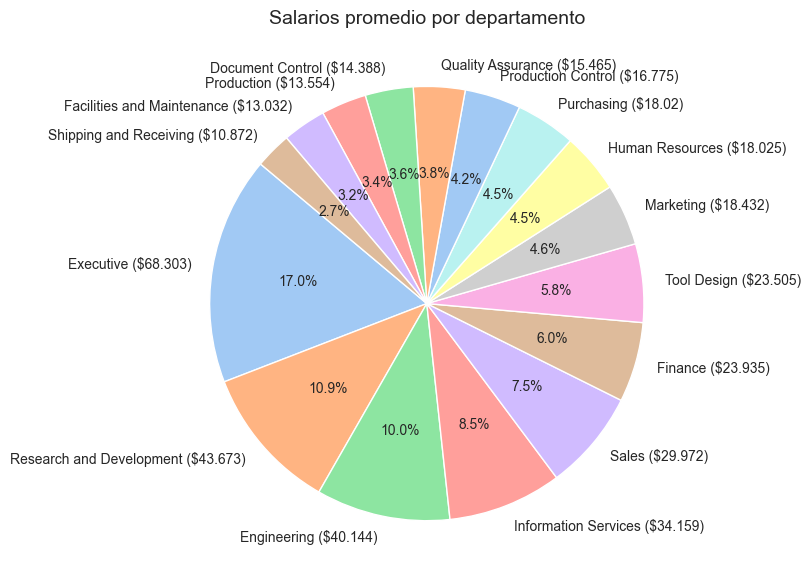

In [25]:
query ="""SELECT HRD.Name AS Departamento,AVG(HREPH.Rate) AS SalarioPromedio
FROM HumanResources.EmployeePayHistory HREPH
JOIN HumanResources.EmployeeDepartmentHistory HRDH
    ON HREPH.BusinessEntityID = HRDH.BusinessEntityID
    AND HRDH.EndDate IS NULL
JOIN HumanResources.Department HRD
    ON HRD.DepartmentID = HRDH.DepartmentID
GROUP BY HRD.Name
ORDER BY SalarioPromedio DESC;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(8, 8))
labels = [f"{dept} (${round(salario, 3)})" for dept, salario in zip(df["Departamento"], df["SalarioPromedio"])]
colors = sns.color_palette("pastel", len(df))

plt.figure(figsize=(8, 8))
plt.pie(df["SalarioPromedio"], labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)

plt.title("Salarios promedio por departamento", fontsize=14)
plt.tight_layout()
plt.show()